## Requirements

In [ ]:
import tensorflow as tf
import numpy as np
from random import sample
from sklearn.decomposition import PCA

class PCAPlotter(tf.keras.callbacks.Callback):
    
    def __init__(self, plt, embedding_model, x_test, y_test):
        super(PCAPlotter, self).__init__()
        self.embedding_model = embedding_model
        self.x_test = x_test
        self.y_test = y_test
        self.fig = plt.figure(figsize=(9, 4))
        self.ax1 = plt.subplot(1, 2, 1)
        self.ax2 = plt.subplot(1, 2, 2)
        plt.ion()
        
        self.losses = []
    
    def plot(self, epoch=None, plot_loss=False):
        x_test_embeddings = self.embedding_model.predict(self.x_test)
        pca_out = PCA(n_components=2).fit_transform(x_test_embeddings)
        self.ax1.clear()
        self.ax1.scatter(pca_out[:, 0], pca_out[:, 1], c=self.y_test, cmap='seismic')
        if plot_loss:
            self.ax2.clear()
            self.ax2.plot(range(epoch), self.losses)
            self.ax2.set_xlabel('Epochs')
            self.ax2.set_ylabel('Loss')
        self.fig.canvas.draw()
    
    def on_train_begin(self, logs=None):
        self.losses = []
        self.fig.show()
        self.fig.canvas.draw()
        self.plot()
        
    def on_epoch_end(self, epoch, logs=None):
        self.losses.append(logs.get('loss'))
        self.plot(epoch+1, plot_loss=True)

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import random
import pandas as pd
import os
import cv2
from time import time
import tarfile
from tensorflow.keras.preprocessing import image as kimage

from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


## Importing data

In [ ]:
train_info = pd.read_csv('train_info.csv', header=None)
lista_imtrain = train_info[1].tolist()
lista_imtrain = lista_imtrain[1:len(lista_imtrain)]
print(len(lista_imtrain))

df_labels = pd.read_csv('train_info.csv',
                         names=['Class']) 
df_labels = df_labels.reset_index()
df_labels['Name'] = df_labels['level_1']
print(df_labels.shape)

train_labels = pd.DataFrame(lista_imtrain[0:len(lista_imtrain)])
train_labels.columns = ['Name']
print(train_labels.shape)

join_labels = train_labels.merge(df_labels, on='Name', how='left')
train_labels = join_labels['Class'].tolist()

annot_data = pd.read_csv("class_list.txt", sep=" ", header=None)
annot_data.columns = ["Number", "Name"]

train_labels_df = pd.DataFrame(train_labels, columns=['Number'])
join_labels = train_labels_df.merge(annot_data, on='Number', how='left')
train_labels_str = join_labels['Name'].tolist()

# Debug variable to limit the number of loaded images
val_info = pd.read_csv('val_info.csv', header=None)
lista_imvalid = val_info[1].tolist()
lista_imvalid = lista_imvalid[1:len(lista_imvalid)]
print(len(lista_imvalid))

df_labels = pd.read_csv('val_info.csv',
                         names=['Class']) 
df_labels = df_labels.reset_index()
df_labels['Name'] = df_labels['level_1']
print(df_labels.shape)

val_labels = pd.DataFrame(lista_imvalid[0:len(lista_imvalid)])
val_labels.columns = ['Name']
print(val_labels.shape)

join_labels = val_labels.merge(df_labels, on='Name', how='left')
val_labels = join_labels['Class'].tolist()

val_labels_df = pd.DataFrame(val_labels, columns=['Number'])
join_labels = val_labels_df.merge(annot_data, on='Number', how='left')
val_labels_str = join_labels['Name'].tolist()

def imreads(path):
    """
    This reads all the images in a given folder and returns the results
    """
    batch_holder = np.zeros((dim_train, 100, 100, 3))
    images = []
    # for image_path in lista_imtrain:
    for i in range(0,len(lista_imtrain)):
        image_path = lista_imtrain[i]
        img = kimage.load_img(path+image_path, target_size=(100, 100))
        img = kimage.img_to_array(img)
        img = np.expand_dims(img, axis=0)
        batch_holder[i, :] = img

    return batch_holder
    
t0 = time()
x_train = imreads('train_set/')
print("Time required: %0.3f seconds." % (time() - t0))

x_train.shape

def imreads(path):
    """
    This reads all the images in a given folder and returns the results
    """
    batch_holder = np.zeros((dim_valid, 100, 100, 3))
    images = []
    # for image_path in lista_imtrain:
    for i in range(0,len(lista_imvalid)):
        image_path = lista_imvalid[i]
        img = kimage.load_img(path+image_path, target_size=(100, 100))
        img = kimage.img_to_array(img)
        img = np.expand_dims(img, axis=0)
        batch_holder[i, :] = img

    return batch_holder
    
t0 = time()
x_test = imreads('val_set/')
print("Time required: %0.3f seconds." % (time() - t0))

x_test.shape

x_train=np.reshape(x_train,(dim_train,30000))/255.
x_test=np.reshape(x_test,(dim_valid,30000))/255.

x_test.shape

y_train = train_labels
y_test = val_labels

y_train_str = train_labels_str
y_test_str = val_labels_str

## Plot examples

Test for the correct output of a possible triplet.

226 106 213
fish_stick ham_sandwich veal_cordon_bleu


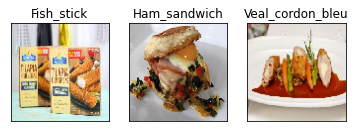

In [ ]:
def plot_triplets(examples, title = ['Anchor','Positive','Negative']):
    plt.figure(figsize=(6, 2))
    for i in range(3):
        plt.subplot(1, 3, 1 + i)
        plt.imshow(np.reshape(examples[i],(100,100,3)))
        plt.title(title[i].capitalize())
        plt.xticks([])
        plt.yticks([])
    plt.show()
    
print(y_train[0],y_train[1],y_train[2])
print(y_train_str[0],y_train_str[1],y_train_str[2])
x_train[0].shape
plot_triplets([x_train[0], x_train[1], x_train[2]], [y_train_str[0],y_train_str[1],y_train_str[2]])

## Batch of triplets

The create_batch() function allows the construction of a dataset with the input numerosity that presents for each observation the example image, one example belonging to the same class (positive) and one belonging to a different class (negative).

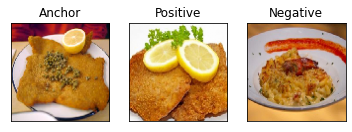

In [ ]:
def create_batch(batch_size=256):
    x_anchors = np.zeros((batch_size, 30000))
    x_positives = np.zeros((batch_size, 30000))
    x_negatives = np.zeros((batch_size, 30000))

    y_anchors = []
    y_positives = []
    y_negatives = []
    
    for i in range(0, batch_size):
        # We need to find an anchor, a positive example and a negative example
        random_index = random.randint(0, len(x_train) - 1)
        y_anchors.append(y_train_str[random_index])
        x_anchor = x_train[random_index]
        y = int(y_train[random_index])

        indices_for_pos = [i for i in range(0,len(y_train)) if y_train[i] == y]
        indices_for_neg = [i for i in range(0,len(y_train)) if y_train[i] != y]
        
        index_pos = random.randint(0, len(indices_for_pos) - 1)
        y_positives.append(y_train_str[indices_for_pos[index_pos]])
        x_positive = x_train[indices_for_pos[index_pos]]

        index_neg = random.randint(0, len(indices_for_neg) - 1)
        y_negatives.append(y_train_str[indices_for_neg[index_neg]])
        x_negative = x_train[indices_for_neg[index_neg]]

        x_anchors[i] = x_anchor
        x_positives[i] = x_positive
        x_negatives[i] = x_negative
        
    return [x_anchors, x_positives, x_negatives]
    # , [y_anchors, y_positives, y_negatives]
    
examples = create_batch(1)
plot_triplets(examples)

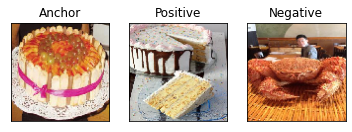

In [ ]:
def create_batch_test(batch_size=int(256/5)):
    x_anchors = np.zeros((batch_size, 30000))
    x_positives = np.zeros((batch_size, 30000))
    x_negatives = np.zeros((batch_size, 30000))

    y_anchors = []
    y_positives = []
    y_negatives = []
    
    for i in range(0, batch_size):
        # We need to find an anchor, a positive example and a negative example
        random_index = random.randint(0, len(x_test) - 1)
        y_anchors.append(y_test_str[random_index])
        x_anchor = x_test[random_index]
        y = int(y_test[random_index])

        indices_for_pos = [i for i in range(0,len(y_test)) if y_test[i] == y]
        indices_for_neg = [i for i in range(0,len(y_test)) if y_test[i] != y]
        
        index_pos = random.randint(0, len(indices_for_pos) - 1)
        y_positives.append(y_test_str[indices_for_pos[index_pos]])
        x_positive = x_test[indices_for_pos[index_pos]]

        index_neg = random.randint(0, len(indices_for_neg) - 1)
        y_negatives.append(y_test_str[indices_for_neg[index_neg]])
        x_negative = x_test[indices_for_neg[index_neg]]

        x_anchors[i] = x_anchor
        x_positives[i] = x_positive
        x_negatives[i] = x_negative
        
    return [x_anchors, x_positives, x_negatives]
    
examples = create_batch(1)
plot_triplets(examples)

## Embedding model

Definition of the embedding network. This has two dense levels of 128 and 251 neurons respectively.

In [ ]:
emb_size = 251

embedding_model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(30000,)),
    tf.keras.layers.Dense(251, activation='sigmoid')
])

embedding_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 128)               3840128   
                                                                 
 dense_7 (Dense)             (None, 251)               32379     
                                                                 
Total params: 3,872,507
Trainable params: 3,872,507
Non-trainable params: 0
_________________________________________________________________


In [ ]:
example = np.expand_dims(x_train[0], axis=0)
example_emb = embedding_model.predict(example)[0]

print(example_emb)
print(len(example_emb))

1/1 [==============================] - 0s 43ms/step
[0.4503495  0.71989113 0.6441606  0.6227503  0.37907895 0.60714465
 0.77975243 0.27271873 0.38231614 0.41422245 0.8668278  0.56753004
 0.32151482 0.5094824  0.22338825 0.42558798 0.4004189  0.38554022
 0.5205759  0.67735857 0.48396432 0.6588748  0.5953283  0.25282666
 0.5608474  0.5507271  0.42478627 0.25696704 0.2888965  0.53604
 0.42608023 0.31026152 0.42205635 0.359198   0.75994426 0.7643645
 0.5498825  0.66194963 0.39069358 0.29394498 0.5029367  0.4012375
 0.32717255 0.4086781  0.5045588  0.43270046 0.63073266 0.3300847
 0.75892025 0.44078934 0.57718295 0.27467722 0.35408995 0.507698
 0.25460276 0.34691077 0.44374242 0.5556835  0.804428   0.34590596
 0.27859342 0.63578403 0.52643955 0.7078637  0.64011496 0.5640048
 0.7167142  0.75177026 0.43996838 0.5825746  0.62642825 0.26519516
 0.1580477  0.40050322 0.714851   0.3966808  0.52713454 0.33907554
 0.46178272 0.51723033 0.3113348  0.32960966 0.55354446 0.6886813
 0.4375277  0.494003

## Siamese network

Application of the embedding network defined above to each of the images in the triplet. The overall output will then be the concatenation of the outputs of the three images, thus 3*251.

In [ ]:
input_anchor = tf.keras.layers.Input(shape=(30000,))
input_positive = tf.keras.layers.Input(shape=(30000,))
input_negative = tf.keras.layers.Input(shape=(30000,))

embedding_anchor = embedding_model(input_anchor)
embedding_positive = embedding_model(input_positive)
embedding_negative = embedding_model(input_negative)

output = tf.keras.layers.concatenate([embedding_anchor, embedding_positive, embedding_negative], axis=1)

net = tf.keras.models.Model([input_anchor, input_positive, input_negative], output)
net.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 30000)]      0           []                               
                                                                                                  
 input_11 (InputLayer)          [(None, 30000)]      0           []                               
                                                                                                  
 input_12 (InputLayer)          [(None, 30000)]      0           []                               
                                                                                                  
 sequential_3 (Sequential)      (None, 251)          3872507     ['input_10[0][0]',               
                                                                  'input_11[0][0]',         

## Triplet loss

Definition of the loss function. Instead of using backpropagation, a loss function is defined that aims to maximise the similarity between the anchor image and the positive sample, but at the same time minimise the distance to the negative sample. An alpha constant of 0.2 is also added to the formula.

In [ ]:
alpha = 0.2

def triplet_loss(y_true, y_pred):
    anchor, positive, negative = y_pred[:,:emb_size], y_pred[:,emb_size:2*emb_size], y_pred[:,2*emb_size:]
    positive_dist = tf.reduce_mean(tf.square(anchor - positive), axis=1)
    negative_dist = tf.reduce_mean(tf.square(anchor - negative), axis=1)
    return tf.maximum(positive_dist - negative_dist + alpha, 0.)

## Data generator

Data generation according to the previous create_batch() function.

In [ ]:
def data_generator(batch_size=256):
    while True:
        x = create_batch(batch_size)
        y = np.zeros((batch_size, 3*emb_size))
        yield x, y

def data_generator_test(batch_size=int(256/5)):
    while True:
        x2 = create_batch_test(batch_size)
        y2 = np.zeros((batch_size, 3*emb_size))
        yield x2, y2

## Model training

Network training. For computational problems, the epochs are at different times but refer to the same network.

16/16 [==============================] - 0s 3ms/step
Epoch 1/10
24/24 [==============================] - 28s 1s/step - loss: 0.1886
Epoch 2/10
24/24 [==============================] - 27s 1s/step - loss: 0.1847
Epoch 3/10
24/24 [==============================] - 27s 1s/step - loss: 0.1821
Epoch 4/10
24/24 [==============================] - 27s 1s/step - loss: 0.1834
Epoch 5/10
24/24 [==============================] - 27s 1s/step - loss: 0.1831
Epoch 6/10
24/24 [==============================] - 27s 1s/step - loss: 0.1830
Epoch 7/10
24/24 [==============================] - 27s 1s/step - loss: 0.1832
Epoch 8/10
24/24 [==============================] - 28s 1s/step - loss: 0.1802
Epoch 9/10
24/24 [==============================] - 27s 1s/step - loss: 0.1790
Epoch 10/10
24/24 [==============================] - 27s 1s/step - loss: 0.1786


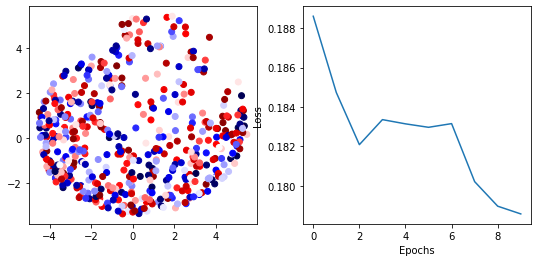

In [ ]:
batch_size = 512
epochs = 10
steps_per_epoch = int(x_train.shape[0]/batch_size)

net.compile(loss=triplet_loss, optimizer='adam')

_ = net.fit(
    data_generator(batch_size),
    steps_per_epoch=steps_per_epoch,
    epochs=epochs, 
    verbose=True,
    callbacks=[
        PCAPlotter(
            plt, embedding_model,
            x_test[:500], y_test[:500]
        )],
    # validation_data=data_generator_test(int(batch_size/5))
)

net.save("Models/siamese_net_val.h5") 

16/16 [==============================] - 0s 3ms/step
Epoch 1/10
24/24 [==============================] - 30s 1s/step - loss: 0.1988
Epoch 2/10
24/24 [==============================] - 29s 1s/step - loss: 0.1989
Epoch 3/10
24/24 [==============================] - 29s 1s/step - loss: 0.1987
Epoch 4/10
24/24 [==============================] - 29s 1s/step - loss: 0.1984
Epoch 5/10
24/24 [==============================] - 28s 1s/step - loss: 0.1993
Epoch 6/10
24/24 [==============================] - 29s 1s/step - loss: 0.1980
Epoch 7/10
24/24 [==============================] - 28s 1s/step - loss: 0.1971
Epoch 8/10
24/24 [==============================] - 29s 1s/step - loss: 0.1975
Epoch 9/10
24/24 [==============================] - 29s 1s/step - loss: 0.1982
Epoch 10/10
24/24 [==============================] - 28s 1s/step - loss: 0.1976


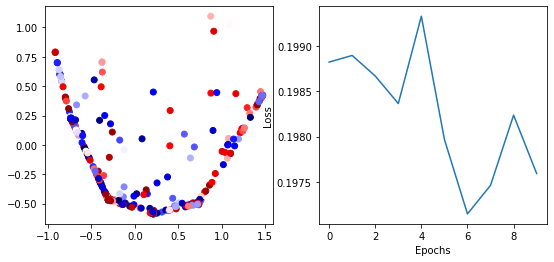

In [ ]:
batch_size = 512
epochs = 10
steps_per_epoch = int(x_train.shape[0]/batch_size)

net.compile(loss=triplet_loss, optimizer='adam')

_ = net.fit(
    data_generator(batch_size),
    steps_per_epoch=steps_per_epoch,
    epochs=epochs, 
    verbose=True,
    callbacks=[
        PCAPlotter(
            plt, embedding_model,
            x_test[:500], y_test[:500]
        )]
)

net.save("Models/siamese_net_2.h5")

16/16 [==============================] - 0s 2ms/step
Epoch 1/100
24/24 [==============================] - 29s 1s/step - loss: 0.1977
Epoch 2/100
24/24 [==============================] - 28s 1s/step - loss: 0.1969
Epoch 3/100
24/24 [==============================] - 28s 1s/step - loss: 0.1955
Epoch 4/100
24/24 [==============================] - 29s 1s/step - loss: 0.1961
Epoch 5/100
24/24 [==============================] - 30s 1s/step - loss: 0.1953
Epoch 6/100
24/24 [==============================] - 28s 1s/step - loss: 0.1946
Epoch 7/100
24/24 [==============================] - 28s 1s/step - loss: 0.1947
Epoch 8/100
24/24 [==============================] - 28s 1s/step - loss: 0.1936
Epoch 9/100
24/24 [==============================] - 29s 1s/step - loss: 0.1914
Epoch 10/100
24/24 [==============================] - 28s 1s/step - loss: 0.1895
Epoch 11/100
24/24 [==============================] - 28s 1s/step - loss: 0.1896
Epoch 12/100
24/24 [==============================] - 28s 1s/step

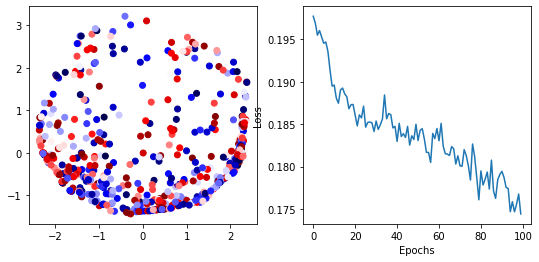

In [ ]:
batch_size = 512
epochs = 100
steps_per_epoch = int(x_train.shape[0]/batch_size)

net.compile(loss=triplet_loss, optimizer='adam')

_ = net.fit(
    data_generator(batch_size),
    steps_per_epoch=steps_per_epoch,
    epochs=epochs, 
    verbose=True,
    callbacks=[
        PCAPlotter(
            plt, embedding_model,
            x_test[:500], y_test[:500]
        )]
)

net.save("Models/siamese_net_3.h5")

16/16 [==============================] - 0s 2ms/step
Epoch 1/100
24/24 [==============================] - 28s 1s/step - loss: 0.1750
Epoch 2/100
24/24 [==============================] - 28s 1s/step - loss: 0.1753
Epoch 3/100
24/24 [==============================] - 28s 1s/step - loss: 0.1752
Epoch 4/100
24/24 [==============================] - 29s 1s/step - loss: 0.1731
Epoch 5/100
24/24 [==============================] - 28s 1s/step - loss: 0.1721
Epoch 6/100
24/24 [==============================] - 28s 1s/step - loss: 0.1730
Epoch 7/100
24/24 [==============================] - 28s 1s/step - loss: 0.1724
Epoch 8/100
24/24 [==============================] - 28s 1s/step - loss: 0.1711
Epoch 9/100
24/24 [==============================] - 28s 1s/step - loss: 0.1688
Epoch 10/100
24/24 [==============================] - 28s 1s/step - loss: 0.1710
Epoch 11/100
24/24 [==============================] - 28s 1s/step - loss: 0.1687
Epoch 12/100
24/24 [==============================] - 28s 1s/step

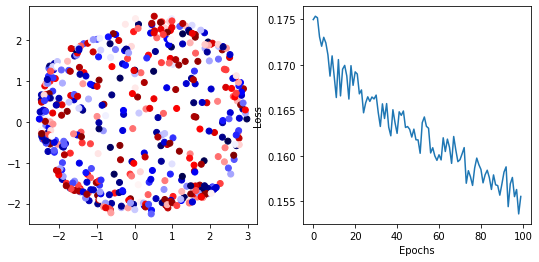

In [ ]:
batch_size = 512
epochs = 100
steps_per_epoch = int(x_train.shape[0]/batch_size)

net.compile(loss=triplet_loss, optimizer='adam')

_ = net.fit(
    data_generator(batch_size),
    steps_per_epoch=steps_per_epoch,
    epochs=epochs, 
    verbose=True,
    callbacks=[
        PCAPlotter(
            plt, embedding_model,
            x_test[:500], y_test[:500]
        )]
)

net.save("Models/siamese_net_4.h5")

16/16 [==============================] - 0s 2ms/step
Epoch 1/100
24/24 [==============================] - 29s 1s/step - loss: 0.1603
Epoch 2/100
24/24 [==============================] - 29s 1s/step - loss: 0.1550
Epoch 3/100
24/24 [==============================] - 29s 1s/step - loss: 0.1538
Epoch 4/100
24/24 [==============================] - 29s 1s/step - loss: 0.1560
Epoch 5/100
24/24 [==============================] - 29s 1s/step - loss: 0.1569
Epoch 6/100
24/24 [==============================] - 29s 1s/step - loss: 0.1545
Epoch 7/100
24/24 [==============================] - 29s 1s/step - loss: 0.1511
Epoch 8/100
24/24 [==============================] - 29s 1s/step - loss: 0.1553
Epoch 9/100
24/24 [==============================] - 28s 1s/step - loss: 0.1533
Epoch 10/100
24/24 [==============================] - 29s 1s/step - loss: 0.1528
Epoch 11/100
24/24 [==============================] - 28s 1s/step - loss: 0.1531
Epoch 12/100
24/24 [==============================] - 28s 1s/step

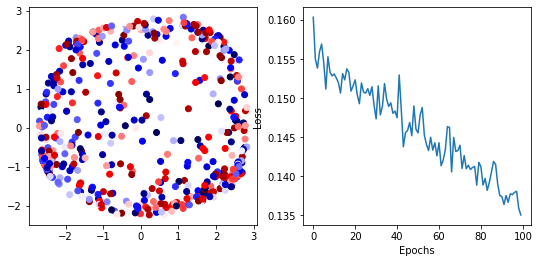

In [ ]:
batch_size = 512
epochs = 100
steps_per_epoch = int(x_train.shape[0]/batch_size)

net.compile(loss=triplet_loss, optimizer='adam')

_ = net.fit(
    data_generator(batch_size),
    steps_per_epoch=steps_per_epoch,
    epochs=epochs, 
    verbose=True,
    callbacks=[
        PCAPlotter(
            plt, embedding_model,
            x_test[:500], y_test[:500]
        )]
)

net.save("Models/siamese_net_5.h5")

## Query

In [ ]:
# load net
alpha = 0.2

def triplet_loss(y_true, y_pred):
    anchor, positive, negative = y_pred[:,:emb_size], y_pred[:,emb_size:2*emb_size], y_pred[:,2*emb_size:]
    positive_dist = tf.reduce_mean(tf.square(anchor - positive), axis=1)
    negative_dist = tf.reduce_mean(tf.square(anchor - negative), axis=1)
    return tf.maximum(positive_dist - negative_dist + alpha, 0.)

from tensorflow import keras
model = keras.models.load_model('Models/siamese_net_5.h5',
                                compile=False)

In [ ]:
train_info = pd.read_csv('Data/train_info.csv', header=None)
lista_imtrain = train_info[1].tolist()
lista_imtrain = lista_imtrain[1:len(lista_imtrain)]
print(len(lista_imtrain))

25034


In [ ]:
# predict each image
prediction_list = []
names_list = []

for i in range(0,len(lista_imtrain)):
    image_path = lista_imtrain[i]
    img = kimage.load_img('train_set/'+image_path, target_size=(100, 100))
    img = kimage.img_to_array(img)
    img = np.reshape(img,(1,30000))/255.

    prediction_list.append(model.predict([img, img, img], verbose=0))
    names_list.append(image_path)

In [ ]:
with open('Models/prediction_list_siamese', 'rb') as fp:
    prediction_list = pickle.load(fp)

In [ ]:
with open('names_list_siamese', 'rb') as fp:
    names_list = pickle.load(fp)

In [ ]:
# create knn algorithm
prediction_list[0][0,:].shape

(192,)

In [ ]:
prediction_list_new = []

for i in range(0,len(prediction_list)):
  prediction_list_new.append(prediction_list[i][0,:])

In [ ]:
prediction_list_new[0].shape

(192,)

In [ ]:
from sklearn.neighbors import NearestNeighbors
neighbor = NearestNeighbors(n_neighbors = 5)
neighbor.fit(prediction_list_new)

NearestNeighbors()

In [ ]:
query_name = 'val_004230.jpg'
img = kimage.load_img('val_set/' + query_name, target_size=(100, 100))
img = kimage.img_to_array(img)
img = np.reshape(img,(1,30000))/255.

In [ ]:
pred_query = model.predict([img, img, img], verbose=0)

In [ ]:
dist, result = neighbor.kneighbors(pred_query)

In [ ]:
dist

array([[0.3435692 , 0.34840202, 0.34910983, 0.37884858, 0.38405684]],
      dtype=float32)

In [ ]:
result

array([[ 6962, 14701, 24968,  3876,  1158]])

In [ ]:
annot_data = pd.read_csv("class_list.txt", sep=" ", header=None)
annot_data.columns = ["Number", "Name"]

In [ ]:
def getQueryLabel(img_name, train=False):
  if not train:
    df_labels = pd.read_csv('val_info.csv',
                          names=['Class'])
  else:
    df_labels = pd.read_csv('train_info.csv',
                          names=['Class'])
  df_labels = df_labels.reset_index()
  df_labels['Name'] = df_labels['level_1']
  return df_labels[df_labels['level_1']==img_name]['Class'].values[0]

In [ ]:
# Plot similar 5 images with given image and similar images dataframe
def plotSimilarImages(img_file, list_similar_indexes, list_similar_distances):

  img = kimage.load_img('val_set/' + img_file, target_size=(224, 224))
  img_class = getQueryLabel(img_file)
  fig, axarr = plt.subplots(2,3,figsize=(15, 8))
  axarr[0,0].imshow(img)
  axarr[0,0].set_title("TEST IMAGE - " + "\nClass: " + annot_data[annot_data['Number']==img_class]['Name'].values[0])
  axarr[0,0].axis('off')

  j, k, m = 0, 0, 1
  for i in range(0,len(list_similar_indexes)):

    sim_index = list_similar_indexes[i]
    sim_path = lista_imtrain[sim_index]
    sim_class = getQueryLabel(sim_path, train=True)
    similarity = list_similar_distances[i]

    similar = kimage.load_img('train_set/' + sim_path, target_size=(224, 224))
    axarr[k,m].imshow(similar)
    axarr[k,m].set_title("Similarity: %.3f" % similarity + "\nClass: " + annot_data[annot_data['Number']==sim_class]['Name'].values[0])
    axarr[k,m].axis('off')

    m += 1
    if m == 3 and k != 1:
      k += 1
      m = 0

    j += 1
    if j == 5:
      break

  plt.tight_layout()
  plt.show()

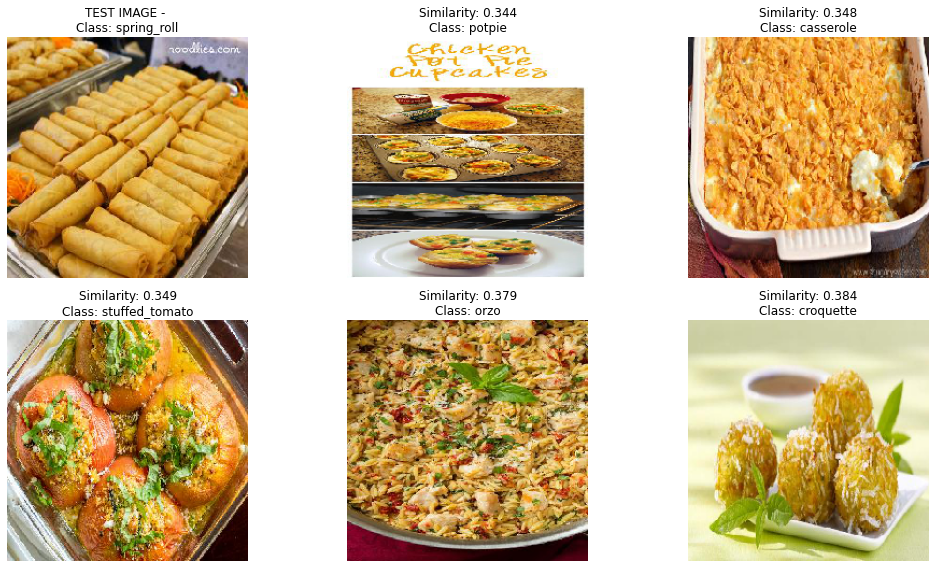

In [ ]:
plotSimilarImages(query_name, result.tolist()[0], dist.tolist()[0])

## Evalutation

In [ ]:
val_info = pd.read_csv('val_info.csv', header=None)
lista_imvalid = val_info[1].tolist()
lista_imvalid = lista_imvalid[1:len(lista_imvalid)]
print(len(lista_imvalid))

In [ ]:
li_accuracy = []

for query_name in lista_imvalid:

  query_img = kimage.load_img('val_set/' + query_name, target_size=(100, 100))
  query_img = kimage.img_to_array(query_img)
  query_img = np.reshape(query_img,(1,30000))/255.

  query_img_class = getQueryLabel(query_name)

  pred_query = model.predict([img, img, img], verbose=0)
  neighbor = NearestNeighbors(n_neighbors = 5)
  neighbor.fit(prediction_list_new)
  dist, result = neighbor.kneighbors(pred_query)
  result = result.tolist()[0]

  accuracy = 0
  for index in result:
    sim_path = lista_imtrain[index]
    sim_class = getQueryLabel(sim_path, train=True)
    if sim_class == query_img_class:
      accuracy += 1

  li_accuracy.append(accuracy/len(result))

In [ ]:
sum(li_accuracy) / len(li_accuracy)

0.015384615384615384